In [199]:
import joblib
# from google.colab import drive

import pandas as pd
import numpy as np
from operator import itemgetter

from matplotlib import pyplot as plt

# from joblib import load

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.pipeline import Pipeline

import gensim
from gensim.corpora import Dictionary
from gensim.models import Nmf, CoherenceModel
from gensim.utils import tokenize

In [3]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [207]:
# Sample size
sample_size = 5000

In [208]:
train = pd.read_csv('assets/Training_set.csv', delimiter='\t', index_col='ix')
train['lemmatized_text'] = train['lemmatized_text'].fillna('')

test = pd.read_csv('assets/Testing_set.csv', delimiter='\t', index_col='ix')
test['lemmatized_text'] = test['lemmatized_text'].fillna('')

In [209]:
n = len(train) if sample_size == -1 else sample_size # to sample or not to sample

# sample the dataframe with balanced classes
sample_df = train.groupby('label').apply(lambda grp: grp.sample(int(n/2), random_state=99))

In [219]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = [list(tokenize(s)) for s in sample_df['lemmatized_text']]

# Create dictionary
dictionary = gensim.corpora.Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 500 + 1, 5))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)

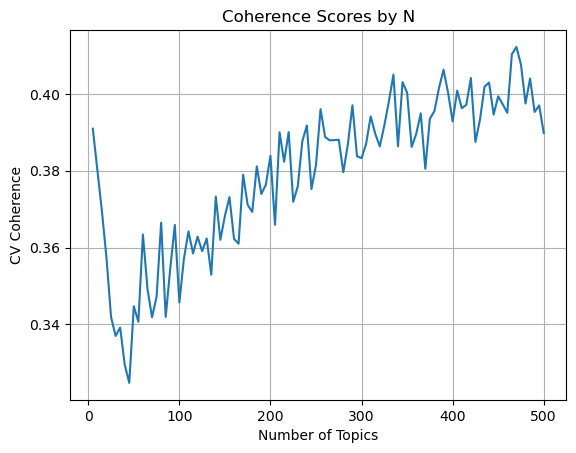

In [218]:
plt.plot([(i + 1) * 5 for i,e in enumerate(coherence_scores)], coherence_scores)
plt.title('Coherence Scores by N')
plt.xlabel('Number of Topics')
plt.ylabel('CV Coherence')
plt.grid()
plt.savefig('nmf_coherence', dpi=600)
plt.show()

In [215]:
pd.DataFrame({
    'Components': [i * 5 for i in range(len(coherence_scores))],
    'Coherence': coherence_scores
})

,Components,Coherence
0,0,0.39094
1,5,0.38013
2,10,0.36946
3,15,0.35731
4,20,0.34194
...,...,...
95,475,0.39751
96,480,0.40400
97,485,0.39530
98,490,0.39699


In [211]:
# pipeline for text features
df = train.reset_index()
nmf = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.80, min_df=0.01, stop_words='english')),
    ('nmf', NMF(n_components=10, init='nndsvd'))
])

features = nmf.fit_transform(df['lemmatized_text'])

In [95]:
for index, topic in enumerate(nmf[1].components_):
    print(f'TOP 10 WORDS FOR TOPIC# {index}:')
    print([nmf[0].get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    # print(nmf[])

TOP 10 WORDS FOR TOPIC# 0:
['september', 'april', 'march', 'december', 'mean', 'english', 'german', 'american', 'lrb', 'rrb']
TOP 10 WORDS FOR TOPIC# 1:
['east', 'people', 'south', 'west', 'northern', 'north', 'region', 'commune', 'department', 'france']
TOP 10 WORDS FOR TOPIC# 2:
['music', 'country', 'number', 'small', 'english', 'write', 'mean', 'form', 'people', 'use']
TOP 10 WORDS FOR TOPIC# 3:
['national', 'american', 'member', 'war', 'country', 'town', 'university', 'county', 'united', 'state']
TOP 10 WORDS FOR TOPIC# 4:
['series', 'world', 'work', 'new', 'film', 'small', 'large', 'people', 'game', 'make']
TOP 10 WORDS FOR TOPIC# 5:
['september', 'july', 'january', 'national', 'american', 'team', 'player', 'football', 'play', 'bear']
TOP 10 WORDS FOR TOPIC# 6:
['river', 'province', 'population', 'area', 'locate', 'district', 'new', 'county', 'large', 'city']
TOP 10 WORDS FOR TOPIC# 7:
['war', 'people', 'old', 'work', 'start', 'world', 'late', 'new', 'time', 'year']
TOP 10 WORDS F

In [96]:
print(df['lemmatized_text'].iloc[10])
[nmf[0].get_feature_names_out()[i] for i in nmf[1].components_[np.argmax(features[10])].argsort()[-10:]]

many still refer to 25 50 and 75 paise as 4 8 and 12 anna respectively not unlike the usage of bit in american english for


['september',
 'july',
 'january',
 'national',
 'american',
 'team',
 'player',
 'football',
 'play',
 'bear']

In [100]:
topic_labels = []

for i,r in df.iterrows():
    main_topic = np.argmax(features[i])
    topic_labels.append(
        {
            'id': i,
            'topic': ', '.join([nmf[0].get_feature_names_out()[i] for i in nmf[1].components_[main_topic].argsort()[-10:]]),
            'label': r['label']
        }
    )

df_topics = pd.DataFrame(topic_labels)
df_topics.head()

,ix,original_text,lemmatized_text,d_chall_score,aoa_mean,aoa_min,aoa_max,conc_rating_mean,conc_rating_min,conc_rating_max,num_lemmas,label
0,0,There is manuscript evidence that Austen conti...,there be manuscript evidence that austen conti...,8.236551,5.809310,3.57,12.12,2.495517,1.33,4.57,37.0,1
1,1,"In a remarkable comparative analysis , Mandaea...",in a remarkable comparative analysis mandaean ...,12.320171,7.499286,2.89,11.94,2.251429,1.46,3.77,21.0,1
2,2,"Before Persephone was released to Hermes , who...",before persephone be release to hermes who hav...,6.594628,5.231351,2.78,11.17,2.537222,1.43,4.86,42.0,1
3,3,Cogeneration plants are commonly found in dist...,cogeneration plant be commonly find in distric...,7.015012,6.742000,3.56,11.53,3.429643,1.52,4.93,32.0,1
4,4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",geneva lrb rrb be the secondmostpopulous city ...,9.847729,5.455000,3.69,12.62,2.399333,1.43,4.79,28.0,1


In [102]:
df_topics.groupby(['topic','label']).count()

id
topic                                              label       
east, people, south, west, northern, north, reg... 0       9845
                                                   1      10329
family, music, world, large, group, number, peo... 0      13115
                                                   1      15694
film, large, form, series, work, game, world, a... 0       5800
                                                   1       8256
music, country, number, small, english, write, ... 0       6959
                                                   1       7289
national, american, member, war, country, town,... 0       7607
                                                   1       8779
river, province, population, area, locate, dist... 0      11833
                                                   1      13131
september, april, march, december, mean, englis... 0      75004
                                                   1      65398
september, july, january, national, american, t... 0      20620
                                                   1      22287
series, world, work, new, film, small, large, p... 0       6047
                                                   1       4058
war, people, old, work, start, world, late, new... 0      30716
                                                   1      32325

In [204]:
# helpers for getting class labels by first topic

nmf =   Pipeline([
            ('tfidf', TfidfVectorizer(max_df=0.80, min_df=0.01, stop_words='english')),
            ('nmf', NMF(n_components=10, init='nndsvd'))
        ])

lda =   Pipeline([
            ('tf', CountVectorizer(max_df=0.80, min_df=0.01, stop_words='english')),
            ('nmf', LatentDirichletAllocation(n_components=10, random_state=99))
        ])

# execute pipeline - return fitted pipeline and H matrix
def train_pipe(df, pipe, n_components=10):
    features = pipe.fit_transform(df['lemmatized_text'])

    return pipe, features

# find and label #1 topic for each document
def apply_labels(labels, nmf, features):
    topic_labels = []

    for i,r in enumerate(labels):
        main_topic = np.argmax(features[i])
        topic_labels.append(
            {
                'id': i,
                'topic': ', '.join([nmf[0].get_feature_names_out()[i] for i in nmf[1].components_[main_topic].argsort()[-10:]]),
                'label': r
            }
        )

    df_topics = pd.DataFrame(topic_labels)
    
    return df_topics

In [134]:
# NMF
labels = df['label']
results = []
for i in range(10,11):
    print(f'Running iteration on {i}')
    pipe, features = train_pipe(df, nmf, i)
    df_topics = apply_labels(labels, pipe, features)
    # return a list of tuples containing (n_components, percentage of positive class)
    results.append((i, df_topics.groupby(['topic']).apply(lambda x: abs(sum(x['label'])/len(x)-.5)).mean()))

results

Running iteration on 2
Running iteration on 3
Running iteration on 4
Running iteration on 5
Running iteration on 6
Running iteration on 7
Running iteration on 8
Running iteration on 9
Running iteration on 10
Running iteration on 11
Running iteration on 12
Running iteration on 13
Running iteration on 14
Running iteration on 15
Running iteration on 16
Running iteration on 17
Running iteration on 18
Running iteration on 19
Running iteration on 20


[(2, 0.04045170510579614),
 (3, 0.038788918604505326),
 (4, 0.040280881997341436),
 (5, 0.03767542940070751),
 (6, 0.0403112697031192),
 (7, 0.03926077577195057),
 (8, 0.04077858628108448),
 (9, 0.037675581702368996),
 (10, 0.037892479489358206),
 (11, 0.03736781803677256),
 (12, 0.0387395706727729),
 (13, 0.040671901679985495),
 (14, 0.037580378396642515),
 (15, 0.03780608313985648),
 (16, 0.03820063865801133),
 (17, 0.039323538375631885),
 (18, 0.03760212470916442),
 (19, 0.038731138853193174),
 (20, 0.03746602761613608)]

In [205]:
# LDA
labels = df['label']
results = []
for i in range(10,11):
    print(f'Running iteration on {i}')
    pipe, features = train_pipe(df, lda, i)
    df_topics = apply_labels(labels, pipe, features)
    # return a list of tuples containing (n_components, percentage of positive class)
    results.append((i, df_topics.groupby(['topic']).apply(lambda x: abs(sum(x['label'])/len(x)-.5)).mean()))

results

Running iteration on 10


[(10, 0.03871426820558631)]

In [206]:
topic_labels = []

for i,r in df.iterrows():
    main_topic = np.argmax(features[i])
    topic_labels.append(
        {
            'id': i,
            'topic': ', '.join([pipe[0].get_feature_names_out()[i] for i in pipe[1].components_[main_topic].argsort()[-10:]]),
            'label': r['label']
        }
    )

df_topics = pd.DataFrame(topic_labels)
df_topics.head()

,id,topic,label
0,0,"season, build, second, book, group, number, wr...",1
1,1,"record, july, january, england, band, album, r...",1
2,2,"february, november, march, english, december, ...",1
3,3,"locate, town, live, population, river, county,...",1
4,4,"february, november, march, english, december, ...",1


In [147]:
results_20 = [(2, 0.04045170510579614),
 (3, 0.038788918604505326),
 (4, 0.040280881997341436),
 (5, 0.03767542940070751),
 (6, 0.0403112697031192),
 (7, 0.03926077577195057),
 (8, 0.04077858628108448),
 (9, 0.037675581702368996),
 (10, 0.037892479489358206),
 (11, 0.03736781803677256),
 (12, 0.0387395706727729),
 (13, 0.040671901679985495),
 (14, 0.037580378396642515),
 (15, 0.03780608313985648),
 (16, 0.03820063865801133),
 (17, 0.039323538375631885),
 (18, 0.03760212470916442),
 (19, 0.038731138853193174),
 (20, 0.03746602761613608)]

In [176]:
scores = pd.DataFrame(results_20, columns=['n',1])
scores.set_index('n', inplace=True)

In [198]:
scores.reset_index(drop=True)
scores['Class_1'] = scores[1] + 0.5
scores['Class_0'] = 1 - scores['Class_1']
scores.drop([1], axis=1, inplace=True)

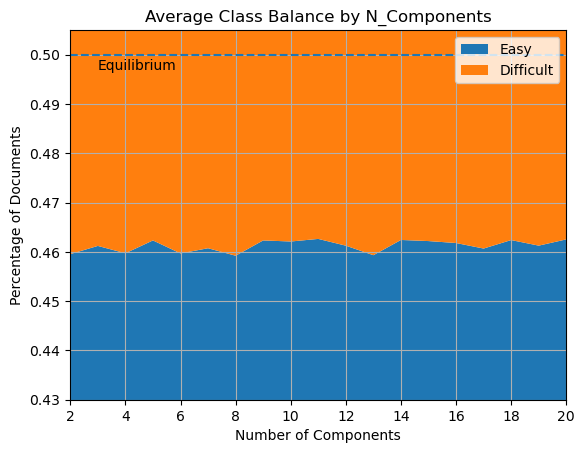

In [197]:
plt.stackplot(scores.index, scores['Class_0'], scores['Class_1'], labels=['Easy','Difficult'])
plt.hlines(.5, 2, 20, linestyles='--')
plt.text(3,.497, 'Equilibrium')
plt.locator_params(integer=True)
plt.ylim(.43,.505)
plt.xlabel('Number of Components')
plt.ylabel('Percentage of Documents')
plt.margins(0,0)
plt.legend()
plt.grid()
plt.title('Average Class Balance by N_Components')
plt.show()

In [115]:
df_topics.groupby(['topic','label']).groups

{('east, people, south, west, northern, north, region, commune, department, france', 0): [187587, 187608, 187613, 187635, 187656, 187674, 187686, 187698, 187729, 187731, 187758, 187797, 187821, 187836, 187837, 187903, 187919, 187926, 187927, 187951, 187987, 187989, 187991, 187997, 188027, 188037, 188038, 188058, 188097, 188098, 188153, 188158, 188179, 188193, 188207, 188210, 188213, 188214, 188234, 188235, 188238, 188239, 188274, 188277, 188325, 188340, 188402, 188479, 188501, 188504, 188508, 188514, 188520, 188541, 188558, 188564, 188633, 188657, 188682, 188685, 188688, 188695, 188726, 188729, 188738, 188745, 188762, 188793, 188805, 188844, 188880, 188881, 188904, 188926, 188932, 188959, 188981, 188997, 189009, 189015, 189028, 189040, 189061, 189068, 189101, 189107, 189120, 189123, 189130, 189146, 189170, 189188, 189238, 189257, 189271, 189292, 189308, 189320, 189322, 189336, ...], ('east, people, south, west, northern, north, region, commune, department, france', 1): [41, 62, 67, 89,

In [ ]:
df_topics.groupby(['topic','label']).groups

{('east, people, south, west, northern, north, region, commune, department, france', 0): [187587, 187608, 187613, 187635, 187656, 187674, 187686, 187698, 187729, 187731, 187758, 187797, 187821, 187836, 187837, 187903, 187919, 187926, 187927, 187951, 187987, 187989, 187991, 187997, 188027, 188037, 188038, 188058, 188097, 188098, 188153, 188158, 188179, 188193, 188207, 188210, 188213, 188214, 188234, 188235, 188238, 188239, 188274, 188277, 188325, 188340, 188402, 188479, 188501, 188504, 188508, 188514, 188520, 188541, 188558, 188564, 188633, 188657, 188682, 188685, 188688, 188695, 188726, 188729, 188738, 188745, 188762, 188793, 188805, 188844, 188880, 188881, 188904, 188926, 188932, 188959, 188981, 188997, 189009, 189015, 189028, 189040, 189061, 189068, 189101, 189107, 189120, 189123, 189130, 189146, 189170, 189188, 189238, 189257, 189271, 189292, 189308, 189320, 189322, 189336, ...], ('east, people, south, west, northern, north, region, commune, department, france', 1): [41, 62, 67, 89,

In [122]:
df_topics.groupby(['topic']).apply(lambda x: abs(sum(x['label'])/len(x)-.5)).mean()

0.03822738380977209